We are interested in the [STEAD](https://github.com/smousavi05/STEAD) dataset.

The STEAD format refers to the STanford EArthquake Dataset, which is a large-scale dataset of seismic waveforms designed for machine learning applications. It contains millions of labeled seismic waveforms, including earthquakes and noise records, with metadata such as event magnitude, depth, station location, and more.

# Downloading and Understanding a STEAD chunk

You can download each chunk from the [Github](https://github.com/smousavi05/STEAD?tab=readme-ov-file) page of the STEAD dataset

Each chunk consists of an HDF5 file (containing waveform data) and a CSV file (containing metadata).

* Note1: some of the unzipper programs for Windows and Linux operating systems have size limits. Try '7Zip' software if had problems unzipping the files.

* Note2: all the metadata are also available in the hdf5 file (as attributes associated with each waveform). But the CSV file can be used to easily select a specific part of the dataset and only read associated waveforms from the hdf5 file for efficiency.

* Note3: For some of the noise data waveforms are identical for 3 components. These are related to single-channel stations where we duplicated the vertical channel for horizontal ones. However, these makeup to less than 4 % of noise data. For the rest, noise is different for each channel.

Before proceeding is useful to understand what is the structure of a hdf5 file... the basic components are:

1. 📂 **Groups (Like Folders in a File System)**: Groups are containers that organize datasets and other groups (like directories in a filesystem). The root group ` / ` is the top-level container in the HDF5 file.
Example:
```
/
├── metadata
├── data
│   ├── event1
│   ├── event2
│   ├── event3
```

2. 📄 **Datasets (Like Files in a Folder)**: Datasets contain the actual numerical or text data (like files in a folder). Datasets can be multi-dimensional (like NumPy arrays).
Example:
```
data/event1  →  [1000x3] array (1000 samples, 3 components)
```

3. 📝 **Attributes (Metadata Associated with Groups or Datasets)**: Attributes store metadata about groups or datasets (like file properties).
Example:
```
data/event1.attrs
├── p_arrival_sample: 230
├── s_arrival_sample: 450
├── coda_end_sample: 800
├── station_name: ABC
├── magnitude: 3.5
```
Attributes cannot be datasets but are small pieces of metadata (e.g., timestamps, location, experiment details)

The structure of a chunk of the STEAD dataset looks like 
```
/
├── data (group)
│   ├── event1 (dataset, 1000x3 array)
│   │   ├── p_arrival_sample: 230
│   │   ├── s_arrival_sample: 450
│   │   ├── coda_end_sample: 800
│   │   ├── source_magnitude: 3.5
│   │   ├── source_distance_km: 15.2
│   │   ├── ...
│   │
│   ├── event2 (dataset, 1200x3 array)
│   │   ├── p_arrival_sample: 250
│   │   ├── s_arrival_sample: 470
│   │   ├── ...
│   │
│   ├── ...

```

In [ ]:
! pip install h5py

<ipython-input-2-5f2b944aa239>:12: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)


total events in csv file: 200000
total events selected: 268


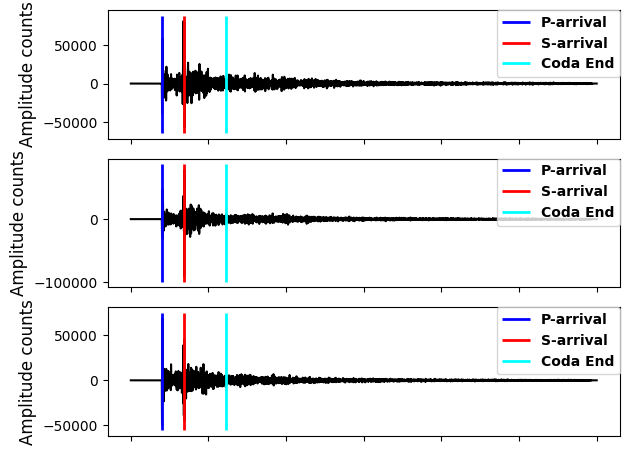

back_azimuth_deg 56.9
coda_end_sample [[1228.]]
network_code CN
p_arrival_sample 400.0
p_status manual
p_travel_sec 4.630000114440918
p_weight 0.5
receiver_code A16
receiver_elevation_m 13.0
receiver_latitude 47.468
receiver_longitude -70.0096
receiver_type HH
s_arrival_sample 686.0
s_status manual
s_weight 0.5
snr_db [72.40000153 61.70000076 62.20000076]
source_depth_km 17.42
source_depth_uncertainty_km 7.6
source_distance_deg 0.18
source_distance_km 19.21
source_error_sec 0.8797
source_gap_deg 37.699
source_horizontal_uncertainty_km 2.68655
source_id 606589340
source_latitude 47.3748
source_longitude -70.2239
source_magnitude 3.7
source_magnitude_author None
source_magnitude_type mb_lg
source_mechanism_strike_dip_rake None
source_origin_time 2015-01-21 05:31:58.92
source_origin_uncertainty_sec 0.76
trace_category earthquake_local
trace_name A16.CN_20150121053158_EV
trace_start_time 2015-01-21 05:31:59.550000


In [ ]:
# Example of data selection and accessing (earthquake waveforms): (Taken directly from github [STEAD](https://github.com/smousavi05/STEAD))

import pandas as pd
import h5py
import numpy as np
import matplotlib.pyplot as plt

file_name = "path/to/STEAD_data/chunk2.hdf5"
csv_file = "path/to/STEAD_data/chunk2/chunk2.csv"

# reading the csv file into a dataframe:
df = pd.read_csv(csv_file)
print(f'total events in csv file: {len(df)}')

# filterering the dataframe
df = df[(df.trace_category == 'earthquake_local') & (df.source_distance_km <= 20) & (df.source_magnitude > 3)]
print(f'total events selected: {len(df)}')

# making a list of trace names for the selected data
ev_list = df['trace_name'].to_list()

# retrieving selected waveforms from the hdf5 file:
dtfl = h5py.File(file_name, 'r')
for c, evi in enumerate(ev_list):

    if c == 1:# i want to plot only the fist one to have an idea
      break

    dataset = dtfl.get('data/'+str(evi))
    # waveforms, 3 channels: first row: E channel, second row: N channel, third row: Z channel
    data = np.array(dataset)

    fig = plt.figure()
    ax = fig.add_subplot(311)
    plt.plot(data[:,0], 'k')
    plt.rcParams["figure.figsize"] = (8, 5)
    legend_properties = {'weight':'bold'}
    plt.tight_layout()
    ymin, ymax = ax.get_ylim()
    pl = plt.vlines(dataset.attrs['p_arrival_sample'], ymin, ymax, color='b', linewidth=2, label='P-arrival')
    sl = plt.vlines(dataset.attrs['s_arrival_sample'], ymin, ymax, color='r', linewidth=2, label='S-arrival')
    cl = plt.vlines(dataset.attrs['coda_end_sample'], ymin, ymax, color='aqua', linewidth=2, label='Coda End')
    plt.legend(handles=[pl, sl, cl], loc = 'upper right', borderaxespad=0., prop=legend_properties)
    plt.ylabel('Amplitude counts', fontsize=12)
    ax.set_xticklabels([])

    ax = fig.add_subplot(312)
    plt.plot(data[:,1], 'k')
    plt.rcParams["figure.figsize"] = (8, 5)
    legend_properties = {'weight':'bold'}
    plt.tight_layout()
    ymin, ymax = ax.get_ylim()
    pl = plt.vlines(dataset.attrs['p_arrival_sample'], ymin, ymax, color='b', linewidth=2, label='P-arrival')
    sl = plt.vlines(dataset.attrs['s_arrival_sample'], ymin, ymax, color='r', linewidth=2, label='S-arrival')
    cl = plt.vlines(dataset.attrs['coda_end_sample'], ymin, ymax, color='aqua', linewidth=2, label='Coda End')
    plt.legend(handles=[pl, sl, cl], loc = 'upper right', borderaxespad=0., prop=legend_properties)
    plt.ylabel('Amplitude counts', fontsize=12)
    ax.set_xticklabels([])

    ax = fig.add_subplot(313)
    plt.plot(data[:,2], 'k')
    plt.rcParams["figure.figsize"] = (8,5)
    legend_properties = {'weight':'bold'}
    plt.tight_layout()
    ymin, ymax = ax.get_ylim()
    pl = plt.vlines(dataset.attrs['p_arrival_sample'], ymin, ymax, color='b', linewidth=2, label='P-arrival')
    sl = plt.vlines(dataset.attrs['s_arrival_sample'], ymin, ymax, color='r', linewidth=2, label='S-arrival')
    cl = plt.vlines(dataset.attrs['coda_end_sample'], ymin, ymax, color='aqua', linewidth=2, label='Coda End')
    plt.legend(handles=[pl, sl, cl], loc = 'upper right', borderaxespad=0., prop=legend_properties)
    plt.ylabel('Amplitude counts', fontsize=12)
    ax.set_xticklabels([])
    plt.show()

    for at in dataset.attrs:
        print(at, dataset.attrs[at])

Let's inspect a bit more the structure of our hdf5 file:

In [ ]:
print("Top-level groups:", list(dtfl.keys()))


Top-level groups: ['data']


In [ ]:
data_group = dtfl['data']  # Access the "data" group
dataset_names = list(data_group.keys())[:10]  # Get first 5 dataset names

print("\nFirst 10 datasets in 'data' group:")
for name in dataset_names:
    dataset = data_group[name]
    print(f"- {name}: shape {dataset.shape}")


First 10 datasets in 'data' group:
- 109C.TA_20060723155859_EV: shape (6000, 3)
- 109C.TA_20061103155652_EV: shape (6000, 3)
- 109C.TA_20061103161223_EV: shape (6000, 3)
- 109C.TA_20061114133221_EV: shape (6000, 3)
- 109C.TA_20061127104640_EV: shape (6000, 3)
- 109C.TA_20061129121745_EV: shape (6000, 3)
- 109C.TA_20061129211102_EV: shape (6000, 3)
- 109C.TA_20061129211301_EV: shape (6000, 3)
- 109C.TA_20061129221547_EV: shape (6000, 3)
- 109C.TA_20070109140205_EV: shape (6000, 3)


In [ ]:
# Get attributes of the first dataset
if dataset_names:
    first_dataset = data_group[dataset_names[0]]
    attr_names = list(first_dataset.attrs.keys())
    print("\nAttributes of the first dataset:")
    print(attr_names)


Attributes of the first dataset:
['back_azimuth_deg', 'coda_end_sample', 'network_code', 'p_arrival_sample', 'p_status', 'p_travel_sec', 'p_weight', 'receiver_code', 'receiver_elevation_m', 'receiver_latitude', 'receiver_longitude', 'receiver_type', 's_arrival_sample', 's_status', 's_weight', 'snr_db', 'source_depth_km', 'source_depth_uncertainty_km', 'source_distance_deg', 'source_distance_km', 'source_error_sec', 'source_gap_deg', 'source_horizontal_uncertainty_km', 'source_id', 'source_latitude', 'source_longitude', 'source_magnitude', 'source_magnitude_author', 'source_magnitude_type', 'source_mechanism_strike_dip_rake', 'source_origin_time', 'source_origin_uncertainty_sec', 'trace_category', 'trace_name', 'trace_start_time']


Now what we would like to do is to convert raw waveforms into Acceleration, Velocity, or Displacement. This passes through the use of obspy.

ObsPy is a Python framework designed for processing and analyzing seismological data. It provides a comprehensive set of tools and functionalities tailored specifically for seismology, including: Data Retrieval, Data Processing, Data Visualization, Data Formats, Utilities

In [ ]:
! pip install obspy

In [ ]:
import obspy
import h5py
from obspy import UTCDateTime
import numpy as np
from obspy.clients.fdsn.client import Client
import matplotlib.pyplot as plt

In [ ]:
def make_stream(dataset):
    '''
    input: hdf5 dataset
    output: obspy stream

    '''
    data = np.array(dataset)

    tr_E = obspy.Trace(data=data[:, 0])
    tr_E.stats.starttime = UTCDateTime(dataset.attrs['trace_start_time'])
    tr_E.stats.delta = 0.01
    tr_E.stats.channel = dataset.attrs['receiver_type']+'E'
    tr_E.stats.station = dataset.attrs['receiver_code']
    tr_E.stats.network = dataset.attrs['network_code']

    tr_N = obspy.Trace(data=data[:, 1])
    tr_N.stats.starttime = UTCDateTime(dataset.attrs['trace_start_time'])
    tr_N.stats.delta = 0.01
    tr_N.stats.channel = dataset.attrs['receiver_type']+'N'
    tr_N.stats.station = dataset.attrs['receiver_code']
    tr_N.stats.network = dataset.attrs['network_code']

    tr_Z = obspy.Trace(data=data[:, 2])
    tr_Z.stats.starttime = UTCDateTime(dataset.attrs['trace_start_time'])
    tr_Z.stats.delta = 0.01
    tr_Z.stats.channel = dataset.attrs['receiver_type']+'Z'
    tr_Z.stats.station = dataset.attrs['receiver_code']
    tr_Z.stats.network = dataset.attrs['network_code']

    stream = obspy.Stream([tr_E, tr_N, tr_Z])

    return stream

def make_plot(tr, title='', ylab=''):
   '''
   input: trace

   '''

   fig = plt.figure()
   ax = fig.add_subplot(1, 1, 1)
   ax.plot(tr.times("matplotlib"), tr.data, "k-")
   ax.xaxis_date()
   fig.autofmt_xdate()
   plt.ylabel(f'{ylab}')
   plt.title(f'{title}')
   plt.show()

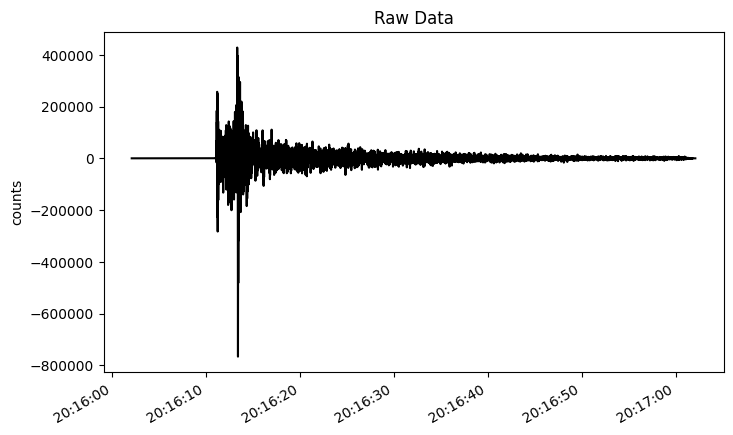

In [ ]:
# reading ONE sample trace from STEAD
dataset = dtfl.get('data/'+str(ev_list[1]))

# convering hdf5 dataset into obspy sream
st = make_stream(dataset)

# ploting the verical component of the raw data
make_plot(st[2], title='Raw Data', ylab='counts')

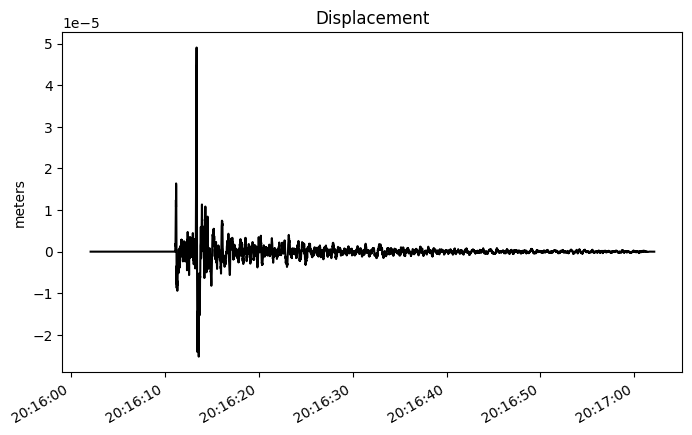

In [ ]:
# downloading the instrument response of the station from IRIS
client = Client("IRIS") # This line initializes a client to interact with the IRIS (Incorporated Research Institutions for Seismology) web services.
                        # IRIS provides access to various seismological data, including waveform data and instrument responses.
inventory = client.get_stations(network=dataset.attrs['network_code'],
                                station=dataset.attrs['receiver_code'],
                                starttime=UTCDateTime(dataset.attrs['trace_start_time']),
                                endtime=UTCDateTime(dataset.attrs['trace_start_time']) + 60,
                                loc="*",
                                channel="*",
                                level="response") # This section retrieves the instrument response information for a specific seismic station
                                                  # (identified by network_code and receiver_code) during a specified time window (trace_start_time to trace_start_time + 60 seconds).

# ll the data in the STEAD dataset are available through IRIS???


# converting into displacement
st = make_stream(dataset)
st = st.remove_response(inventory=inventory, output="DISP", plot=False) # removes the instrument response from the seismic data (st) using the inventory obtained earlier.
                                                                        # It converts the seismic data from its original units (likely counts or volts) to displacement (output="DISP").

# we utilize the instrument response information obtained from IRIS to convert the raw seismic data
# from its original units (typically counts or volts) to physical units like displacement, correcting
#for the instrument's sensitivity and frequency response (...)"

# ploting the verical component
make_plot(st[2], title='Displacement', ylab='meters')

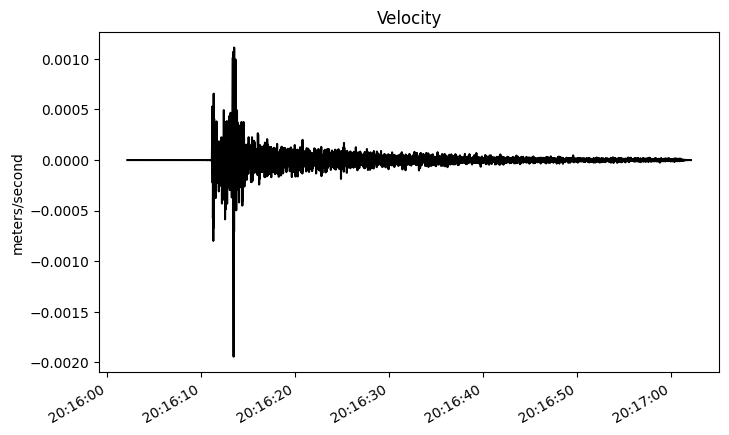

In [ ]:
# converting into velocity
st = make_stream(dataset)
st = st.remove_response(inventory=inventory, output='VEL', plot=False)

# ploting the verical component
make_plot(st[2], title='Velocity', ylab='meters/second')

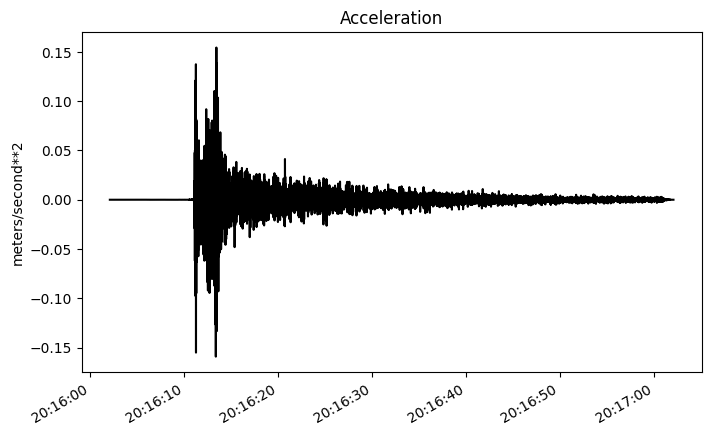

In [ ]:
# converting into acceleration
st = make_stream(dataset)
st.remove_response(inventory=inventory, output="ACC", plot=False)

# ploting the verical component
make_plot(st[2], title='Acceleration', ylab='meters/second**2')

# hdf5 to Torch_ensor

In [ ]:
! pip install obspy

In [ ]:
import pandas as pd
import h5py
import numpy as np
import obspy
import torch
from obspy import UTCDateTime
from obspy.clients.fdsn import Client

file_name = "path/to/STEAD_data/chunk2.hdf5"
csv_file = "path/to/STEAD_data/chunk2/chunk2.csv"

# reading the csv file into a dataframe:
df = pd.read_csv(csv_file)
print(f'total events in csv file: {len(df)}')
df = df[~df.network_code.isin(['IV', 'HA', 'KO', 'HP', 'FR', 'S', 'TU'])]

# making a list of trace names for the selected data
ev_list = df['trace_name'].to_list()
print(len(ev_list))

<ipython-input-2-052e8900cc58>:13: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)


total events in csv file: 200000
198724


In [ ]:
#custom to deal with 12Z casescases

def make_stream(dataset):
    '''
    input: hdf5 dataset
    output: obspy stream

    '''
    data = np.array(dataset)

    tr_E = obspy.Trace(data=data[:, 0])
    tr_E.stats.starttime = UTCDateTime(dataset.attrs['trace_start_time'])
    tr_E.stats.delta = 0.01
    if(dataset.attrs['network_code'] == 'PB'):
        tr_E.stats.channel = dataset.attrs['receiver_type']+'1'
    else:
        tr_E.stats.channel = dataset.attrs['receiver_type']+'E'
    tr_E.stats.station = dataset.attrs['receiver_code']
    tr_E.stats.network = dataset.attrs['network_code']
    if(dataset.attrs['network_code'] == 'GM'):
        tr_E.stats.location = '01'
    elif(dataset.attrs['network_code'] in ['II', 'US', 'NM', 'ET']):
        tr_E.stats.location = '00'

    tr_N = obspy.Trace(data=data[:, 1])
    tr_N.stats.starttime = UTCDateTime(dataset.attrs['trace_start_time'])
    tr_N.stats.delta = 0.01
    if(dataset.attrs['network_code'] == 'PB'):
        tr_N.stats.channel = dataset.attrs['receiver_type']+'2'
    else:
        tr_N.stats.channel = dataset.attrs['receiver_type']+'N'
    tr_N.stats.station = dataset.attrs['receiver_code']
    tr_N.stats.network = dataset.attrs['network_code']
    if(dataset.attrs['network_code'] == 'GM'):
        tr_N.stats.location = '01'
    elif(dataset.attrs['network_code'] in ['II', 'US', 'NM', 'ET']):
        tr_N.stats.location = '00'

    tr_Z = obspy.Trace(data=data[:, 2])
    tr_Z.stats.starttime = UTCDateTime(dataset.attrs['trace_start_time'])
    tr_Z.stats.delta = 0.01
    tr_Z.stats.channel = dataset.attrs['receiver_type']+'Z'
    tr_Z.stats.station = dataset.attrs['receiver_code']
    tr_Z.stats.network = dataset.attrs['network_code']
    if(dataset.attrs['network_code'] == 'GM'):
        tr_Z.stats.location = '01'
    elif(dataset.attrs['network_code'] in ['II', 'US', 'NM', 'ET']):
        tr_Z.stats.location = '00'

    stream = obspy.Stream([tr_E, tr_N, tr_Z])

    return stream

In [ ]:
client = Client("IRIS")

chunk = "chunk2"

waveform_list = []

In [ ]:
# retrieving selected waveforms from the hdf5 file:
dtfl = h5py.File(file_name, 'r')
for c, evi in enumerate(ev_list):

    if c%100 == 0:
      print(f'{c}')

    dataset = dtfl.get('data/'+str(evi))

    # waveforms, 3 channels: first row: E channel, second row: N channel, third row: Z channel
    data = np.array(dataset) # 6000x3

    # convering hdf5 dataset into obspy sream
    st = make_stream(dataset)


    inventory = client.get_stations(network=dataset.attrs['network_code'],
                                station=dataset.attrs['receiver_code'],
                                starttime=UTCDateTime(dataset.attrs['trace_start_time']),
                                endtime=UTCDateTime(dataset.attrs['trace_start_time']) + 60,
                                loc="*",
                                channel="*",
                                level="response")


    # converting into displacement
    st = make_stream(dataset)

    try:
        st = st.remove_response(inventory=inventory, output="ACC", plot=False)
    except Exception as e:
        print(f"Stream-wide response removal failed: {e}")
        traces = np.full((3, 6000), np.nan, dtype=np.float64)  # Use float32 for compatibility  # Shape: (3, datapoints)
        waveform_list.append(traces)
        continue


    st = st.remove_response(inventory=inventory, output="ACC", plot=False)

    # Convert ObsPy stream to NumPy array (shape: 3 x datapoints)
    traces = np.array([tr.data for tr in st])  # Shape: (3, datapoints)

    # Store in list
    waveform_list.append(traces)

In the following we check if it's possible to parallelize the process of conversion. If on your machine it's not possible we suggest to either run the notebook on google colab or to convert the loop into a single processor one (which should be straightforward)

In [ ]:
import multiprocessing
print(multiprocessing.cpu_count())

In [ ]:
import os
print(f"Max threads: {os.cpu_count()}")

In [ ]:
import threading
import time
from concurrent.futures import ThreadPoolExecutor

def worker(n):
    """Simple function that simulates work by sleeping."""
    print(f"Thread {threading.current_thread().name} is running")
    time.sleep(2)  # Simulates some work
    return n

# Set number of threads (e.g., 4)
num_threads = 4

start_time = time.time()

with ThreadPoolExecutor(max_workers=num_threads) as executor:
    results = list(executor.map(worker, range(num_threads)))

end_time = time.time()

print(f"Execution time: {end_time - start_time:.2f} seconds")

# if it remains an average of 2 sec then he workers are all working and there is not a cap


## Parallel Loop

In [ ]:
import h5py
import numpy as np
import os
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from concurrent.futures import ProcessPoolExecutor
from multiprocessing import shared_memory
import time

In [ ]:
import numpy as np
import h5py
import time
import os
from concurrent.futures import ThreadPoolExecutor
from multiprocessing import Array
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from obspy.core.stream import Stream

# Shared memory parameters
num_channels = 3
num_datapoints = 6000
num_events = len(ev_list)  # Make sure ev_list is defined

# Create a shared NumPy array using multiprocessing.Array
shared_array_base = Array("d", num_events * num_channels * num_datapoints)  # Shared flat array
shared_array = np.frombuffer(shared_array_base.get_obj(), dtype=np.float64)
shared_array = shared_array.reshape((num_events, num_channels, num_datapoints))
shared_array[:] = np.nan  # Initialize with NaN

client = Client("IRIS")  # Persistent FDSN client

def process_waveform(index_evi):
    """Function to process a single waveform event and write directly to shared memory."""
    index, evi = index_evi

    with h5py.File(file_name, "r") as dtfl:
        dataset = dtfl.get(f"data/{evi}")
        if dataset is None:
            return  # Skip if missing

        try:
            # Convert dataset into ObsPy stream (Assuming make_stream is defined elsewhere)
            st = make_stream(dataset)

            # Pre-fetch metadata
            inv = client.get_stations(
                network=dataset.attrs["network_code"],
                station=dataset.attrs["receiver_code"],
                starttime=UTCDateTime(dataset.attrs["trace_start_time"]),
                endtime=UTCDateTime(dataset.attrs["trace_start_time"]) + 60,
                loc="*",
                channel="*",
                level="response"
            )

            # Remove response
            st = st.remove_response(inventory=inv, output="ACC", plot=False)

            # Write results directly to shared array
            shared_array[index] = np.array([tr.data for tr in st])

        except Exception as e:
            print(f"Failed processing event {evi}: {e}")


In [ ]:
# Use limited workers
# num_workers = min(os.cpu_count(), len(ev_list))
num_workers = 32

start_time = time.time()

with ProcessPoolExecutor(max_workers=num_workers) as executor:
    executor.map(process_waveform, enumerate(ev_list))

end_time = time.time()

print(f"Execution time: {end_time - start_time:.2f} seconds")

# Convert shared array into a regular NumPy array (optional)
waveform_array = shared_array.copy()
print(waveform_array.shape)

In [ ]:
# Convert list to a PyTorch tensor of shape (n_samples, 3, datapoints)
waveform_tensor = torch.tensor(np.stack(waveform_array), dtype=torch.float64)  # (n_samples, 3, datapoints)

# Save the tensor to a .pt file
torch.save(waveform_tensor, f"path/to/save/{chunk}_acceleration.pt")

# Close HDF5 file
#dtfl.close()

print(f"Tensor saved as {chunk}_acceleration.pt with shape:", waveform_tensor.shape)

In [ ]:
# check to see it prints the right stuff
import matplotlib.pyplot as plt

direction = 0

for idx in range(10):
  fig = plt.figure()
  ax = fig.add_subplot(1, 1, 1)
  ax.plot(waveform_array[idx,direction,:], "k-")
  plt.ylabel('acceleration')
  plt.title('timesteps')
  plt.show()



In [ ]:
# Convert list to a PyTorch tensor of shape (n_samples, 3, datapoints)
waveform_tensor = torch.tensor(np.stack(waveform_array), dtype=torch.float64)  # (n_samples, 3, datapoints)

# Save the tensor to a .pt file
torch.save(waveform_tensor, f"STEAD_data/{chunk}/{chunk}_acceleration.pt")

# Close HDF5 file
dtfl.close()

print(f"Tensor saved as {chunk}_acceleration.pt with shape:", waveform_tensor.shape)

In [ ]:
accelerations = torch.load(f"STEAD_data/{chunk}/{chunk}_acceleration.pt")
print(accelerations.shape)

In [ ]:
import matplotlib.pyplot as plt

idx = 1
direction = 0

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(accelerations[idx,direction,:], "k-")
plt.ylabel('acceleration')
plt.title('timesteps')
plt.show()